## 강화학습  assignment1

# Playing Atari with Deep Reinforcement Learning

## 0. Abstract

-High-dimensional 센서 input을 사용하여 RL을 학습하는데 성공한 첫번째 딥러닝 모델

-CNN과 변형된 Q-learning 사용

-입력값: raw pixels, 출력값: 미래 보상을 추정하는 Value function


## 1. Introduction

-Agents를 시각 혹은 음성 같은 high-dimensional 센서 input을 직접 입력 받아 agents를 학습시키는 것이 RL의 오랜 과제들 중 하나.

-이러한 도메인에서 가장 성공한 RL은 linear value function, policy representations이 결합된 handcrafted feature과 연관되어 있음

-이러한 시스템의 성능은 feature의 표현 품질에 연관 있음.

-최근, 딥러닝은 raw 센서 데이터로부터 high-level feature를 뽑아내 vision, speech 분야에 활용함으로써 획기적인 발전을 이뤄내고 있는데, neural network, CNN, multi perceptron, RNN 등의 방법이 센서 데이터가 있는 RL에 효과적인지 확인해보자 함.

-그러나, RL에 문제들이 존재함.

1. 딥러닝은 수많은 hand-labeled된 훈련 데이터들이 필요한데 RL은 자주 발생되는 sparse, noisy, delayed된 결과 reward로부터 학습되어야 함 -> 딥러닝은 input에 대한 결과가 직접 작성되므로 계산의 시간이 적은 반면, RL에서는 어떠한 행위를 하면 trial & error를 통해 그 행위에 대한 결과를 알기까지 시간이 필요한 delay 발생

2. 하나의 행위가 다른 것들과 연관성이 높음 -> 현재 상태의 행동이 다음 상태의 보상에 영향을 주는 등 상호연관성 매우 높음.

3. 알고리즘이 새로운 behavior를 배울 때마다 data의 distribution이 변하게 되는데, 데이터의 분포가 고정되어 있다고 가정하는 딥러닝의 assumption과 충돌하여 문제 발생.

-복잡한 RL환경인 raw 비디오로부터 CNN을 사용하여 앞의 문제들 극복하고 policies 훈련시킴.

-변형된 Q-Learning 알고리즘, SGD(Stochastic gradient descent)를 사용하여 네트워크 훈련시킴.

-문제점2번 해결위해, 이전상태의 집합을 무작위로 선택하는 알고리즘인 experience replay mechanism 사용-> 이전행동에 대한 많은 학습 분포를 부드럽게 만듦.

-Atari게임에 적용함. 목표는 하나의 neural network agent가 가능한 많은 게임을 배우는 것!

-network에게 특정 게임의 정보나, handcrafted feature 정보는 제공하지 않음. 오직, 비디오의 시각 데이터, Reward, 터미널로부터 오는 신호, 가능한 몇 개의 행동으로만 학습함. network의 architecture, hyper parameter은 모든 게임에 같게 유지




## 2. Background

In [ ]:
#논문 읽기 전 강화학습에 대해 먼저 공부한 내용으로 background 부분 대신합니다

((이부분은 그냥 제가 공부하려고 정리한 부분입니다))

문제 정의

우선, 강화학습이 다루는 문제
-> 주변 상태에 따라 어떤 행동을 할지 판단을 내리는 주체인 에이전트가 있고, 에이전트가 속한 환경이 있는데
에이전트가 행동을 하면 그에 따라 상태가 바뀌게 되고, 보상을 받을 수도 있음. 
즉, 강화하급의 목표는 주어진 환경에서 보상을 최대한 많이 받을 수 있는 에이전트를 학습하는 것!

용어들 정의해보면, 

상태(state)는 현재 시점에서 상황이 어떠한지 나태내는 값의 집합. 
가능한 모든 상태의 집합은 state space, S
특정 시각 t에서의 상태값은 St.

행동(Action)은 우리가 취할 수 있는 선택지. 
가능한 모든 행동의 집합은 action space, A
특정 시각 t에서의 상태 st를 본 뒤 취했던 행동 at.

에이전트가 어떤 행동을 했을 때 따라오는 이득: 보상(Reward).
보상은 높을 수록 좋고,
보상에 -1을 곱하면 비용(cost)인데, 이는 낮을 수록 좋음

이 때 주의할 점은! 보상이 현재 상태, 행동에 대해서만 즉각적인 값임!
장기적으로 가장 좋은 결과를 얻을 수 있는 행동을 고르기 위해서는 현재 보상이 제일 높은 행동이 아니라, 누적 보상이 제일 높은 행동을 골라야 함.
-> 같은 알고리즘이더라도 보상 함수를 어떻게 정의하느냐에 따라 성능이 달라짐, 각 경우에서 보상을 어떻게 할당할지 결정하는 것 = 'reward shaping'

주어진 문제 상황에서 행동하는 주체- Agent에이전트, 예를 들어, 게임에서는 플레이어가 조작하는 캐릭터, 또는 조작하는 플레이어 본인이 에이전트임.

에이전트가 판단하는 방식 - 정책(Policy), 정책을 수학적으로 나타내면, 상태에 따른 행동의 조건부 확률이고, 보통 현재 상태가 s일때 확률 분포 자체는 π(⋅|s), 특정 행동 a가 뽑힐 확률 π(a|s)

현재 학습중인 정책(target policy)은 π, 과거에 데이터를 수집할 때 취했던 정책(behavior policy)은 , 정책 중 가장 좋은 것은 optimal policy π∗

+한번에 하나의 에이전트가 아니라 여러 에이전트를 동시에 다루는 문제 multi-agent 세팅

환경(environment): 문제 세팅 그 자체. ex) 게임- 에이전트가 취할 수 있는 행동, 그에 따른 보상 등 게임 자체의 모든 규칙이 환경! 
즉 S,A,R 등은 모두 환경의 구성 요소임. 플레이어가 조작할 수 있는 부분은 에이전트, 그 외의 모든 정해진 것들은 환경

강화학습의 중요한 가정 중 하나- Markov property를 가진다는 것.
=> 현재 상태만 참조하면 항상 필요한 모든 정보를 알 수 있다는 뜻.
수학적으로 나타내면 s t+1와 rt는 st,at,만의 함수라는 것이고, 그보다 과거의 상태/행동 si(i<t)와 ai(i<t)에서 얻을 수 있는 필요한 정보는 이미 st에 담겨 있어야 하므로 알 필요가 없다
ex) 게임 상태를 스크린 샷으로 정의하는 경우, 테트리스는 모든 정보가 현재 화면의 스크린샷에 담겨 있기 때문에 Markov property를 만족하는 환경이지만, 배틀그라운드의 경우 현재 화면 스크린샷 하나만으로는 (과거에 봐서 알고 있는) 자신 기준 뒤쪽에 떨어져 있는 아이템 정보는 알 수 없기 때문에 Markov property를 만족하지 못하게 된다!
-> deep reinforcement learning에서는, 이런 경우 rnn 등을 추가해 과거 상태를 요약하는 벡터를 만들어 근사적으로 해겨람. 즉, rnn의 internal context vector가 state space 에 추가된다. 

초기상태(inital state)는 에이전트가 처음으로 환경과 상호작용할 때의 상태. 게임으로 치면 시작화면, 가능한 초기상태는 여러 개일 수 있고, 그를 나타내는 확률분포가 있을 수 있음.

종료상태(terminal state)는 도달할 경우 더 이상의 행동이 불가능한 상태. 게임으로 치면 게임오버 또는 클리어 했을 때.

에피소드(episode)는 initial state부터 terminal state까지 에이전트가 거친 상태,행동,보상의 sequence를 의미. 




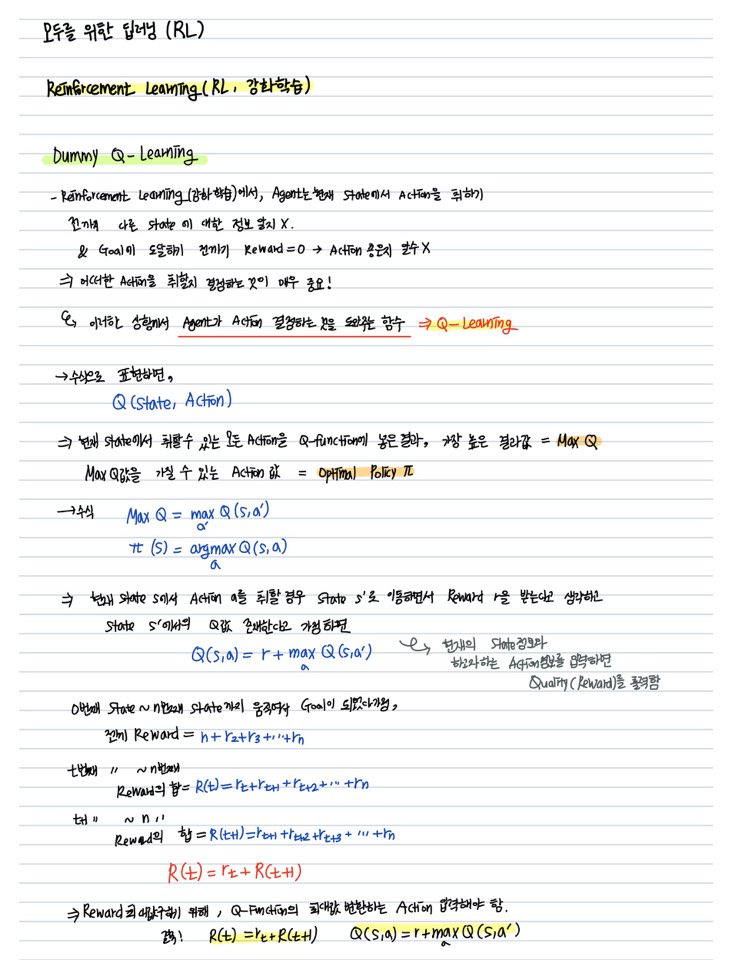

In [2]:
from IPython.display import Image
 
Image("1.jpg") 

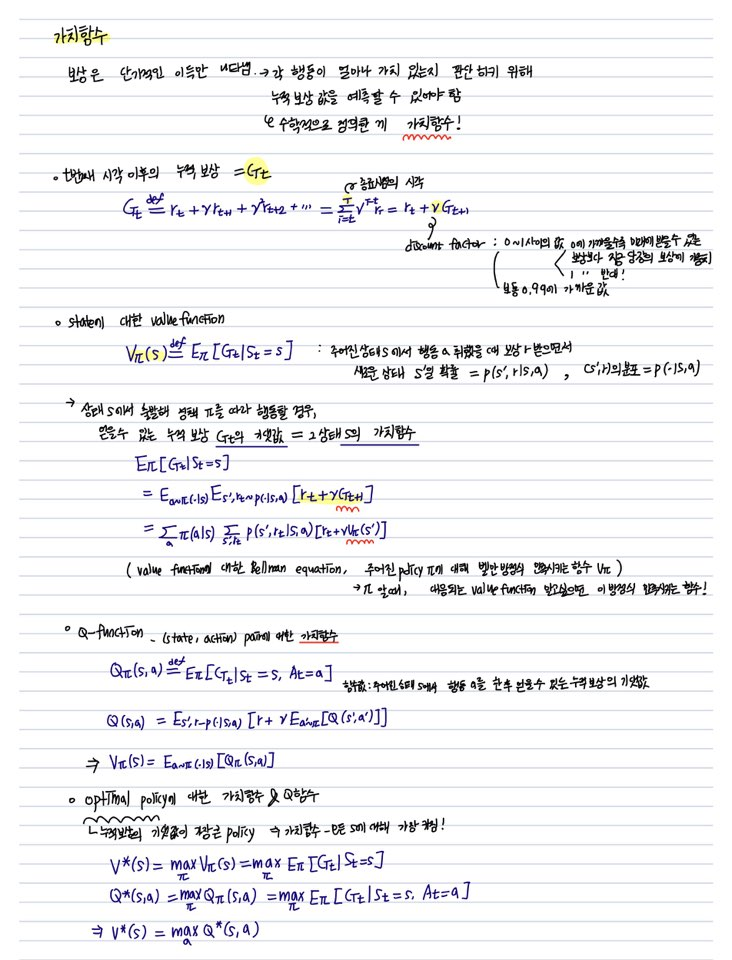

In [3]:
Image("2.jpg") 

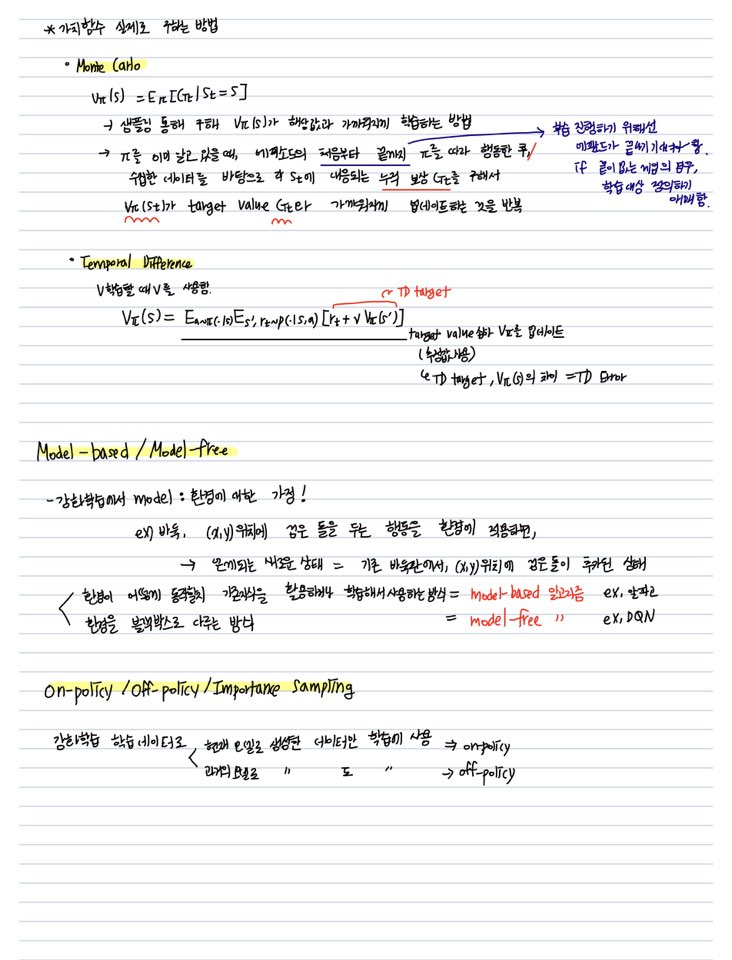

In [4]:
Image("3.jpg") 

## 4. Deep Reinforcement Learning

-최근 컴퓨터 비전과 음성 인식은 딥러닝에서 효과적. raw이미지를 직접 넣어서 SGD로 훈련하는 것이 가장 성공적인 접근법. 많은 데이터로 훈련하는 것이 hand-crafted feature보다 좋음 -> 이를 이용해 RL에 딥러닝을 접목시켜 RGB이미지로 직접 training data를 효과적으로 처리할 수 있었음.

-TD-Gammon과 달리, experience replay 사용!
Experience replay: 매 time-step마다 agent가 경험한 것을 저장하고, 각 에피소드들이 데이터 셋으로 저장됨. 저장된 데이터 셋에서 임의로 추출한 experience 샘플을 가지고 Q-learning 학습

-experience replay 후, agent는 greedy policy에 따라 action을 실행함. Neural network의 input으로 가변적인 history를 사용하는 것은 어렵지만, deep Q Algorithm에서는, ϕ함수를 사용하여 고정 길이의 history를 입력으로 사용 
=> Deep Q learning

-DQN이 기존의 Q-Learning보다 가지는 장점

1. each step의 experience가 잠재적으로 많은 weight update에 재사용되므로, experience를 weight update 한번만 사용하는 기존의 방법보다 훨씬 효율적.

2. sample들을 E-greedy 알고리즘을 통해 랜덤화하여 sample들간의 높은 상관관계를 깨 update의 효율성 높임

3. 기존 on-policy로 학습을 하면, 매개변수가 학습된 다음 데이터 샘플을 결정. Training distribution 변화로 인해 원치 않는 feedback loops들이 발생하고, parameter들이 local minimum으로 수렴하거나 발산하는 문제점이 있었는데,
-> experience replay를 사용하므로 behavior distribution이 균형을 이루고, parameter의 발산이나 진동을 피하고 학습이 매끄럽게 진행됨.
*experience replay-> q-value approximation 안정화!

(이 때, experience replay를 통해 학습하기 위해서는 behavior policy의 parameter과 learning policy의 parameter가 다르기 때문에 off-policy사용함)

=>DQN에서는 replay memory 안에 마지막 N개의 experience만을 저장하고, update 하기위해 랜덤하게 data set으로부터 추출함!!


-DQN 단점
1. replay memory의 최대 용량까지 저장하고, 저장한 용량에서 랜덤하게 뽑아냄 => memory buffer가 중요한 transition(실행,학습할 때 더 좋았던 state, action, reward, next state)들을 구별하지 않음.  + memory size가 유한하므로 항상 overwrite(minibatch로 뽑았을 때 남아있는 것들을 계속 겹쳐쓰고 덮어씀.)함.


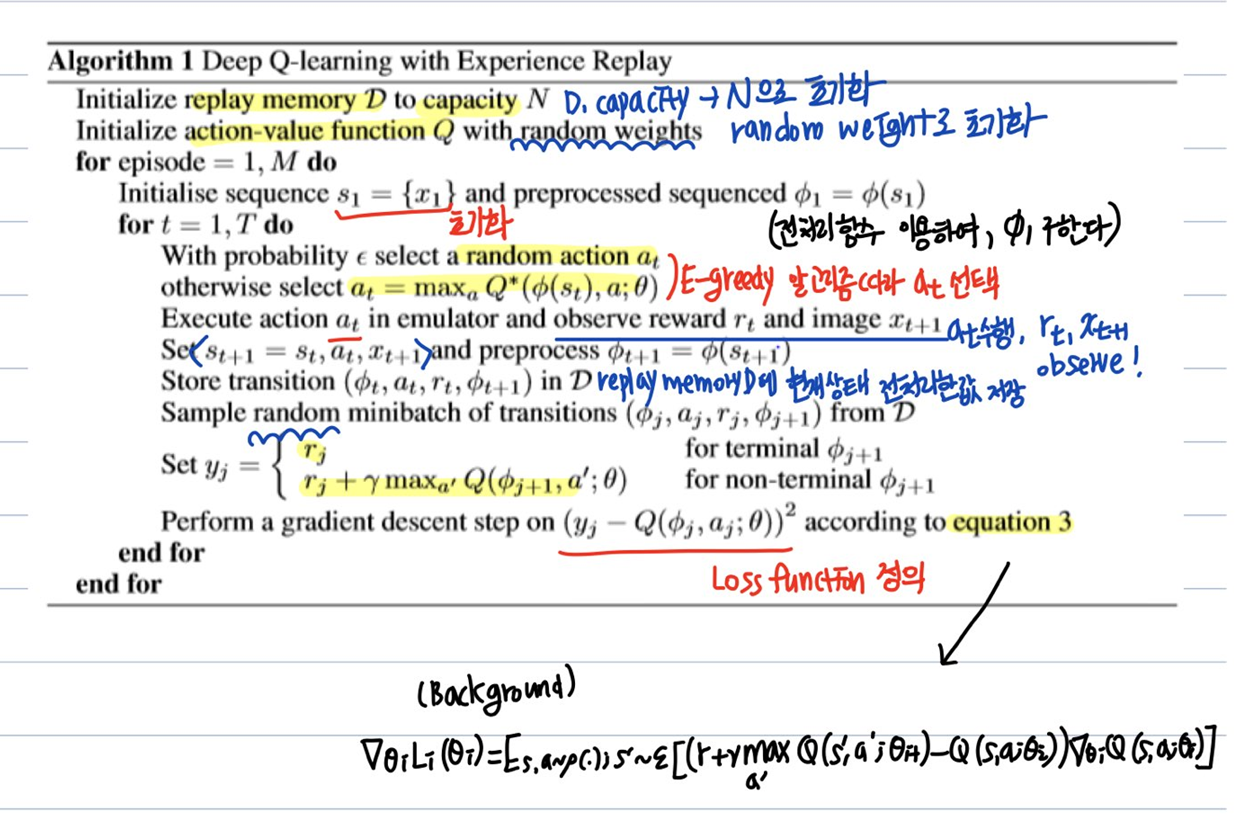

In [12]:
Image("c4.png") 

## 4-1 Preprocessing and model architecture

### Preprocessing:

-129 color palette를 가진 201 x 160 (x3channel) pixel images인 raw Atari frames을 직접적으로 작업하는 건 많은 계산양을 필요로 하므로, input의 dimensionality 줄이는 preprocessing 과정 진행

-RGB로 표현된 이미지를 Gray-scale로 변환 -> 110x84이미지로 down-sampling -> GPU 연산 위해 게임 진행부분만 보이도록 84x84로 잘라냄

-위의 알고리즘의 전처리함수인 ϕ()에서 마지막 4개의 frame에 대해서만 preprocessing하여 stack에 넣어두고, 입력에 대한 Q-function의 값 구하기 위해 사용


### Model Architecture

-Q-value를 구하는 두가지 방법

1. history와 action을 input으로, output으로 history와 action에 대해 예측된 Q-value 구하는 방법

2. history만을 input으로, output으로 각 행동에 대해 예측된 Q-value 구하는 방법

-1번은 history에 해당하는 action들에 대해서 하나의 DNN으로 각각 분리된 forward 연산을 진행해야 하므로 2번 방법 사용함. -> 하나의 DNN을 통해 주어진 state에서 가능한 모든 action들에 대한 Q-value를 계산하기 때문에 좀 더 효율적.


#### DQN
-이 알고리즘의 핵심은 Q-learning이고, Q-value 학습이 가장 중요함

-픽셀단위로 서로 다른 이미지를 서로 다른 state로 정의한다면 우주의 원자수 만큼이나 많은 state 수가 될것이다. 그러나 neutral network는 이미지 정보에서 특징(features)를 찾아내는데 탁월한 장점이 있다.neural network를 구축하고 이미지 정보를 입력으로 사용하고 Q-value를 출력으로 사용하는 system을 구축-> neural network를 value function approximation에 사용.

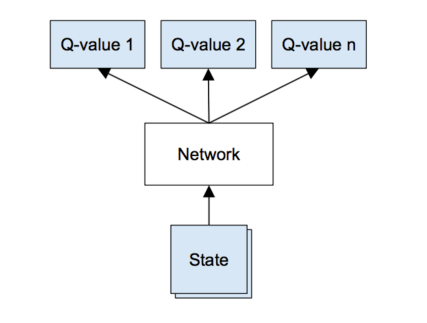

In [7]:
Image("c2.png") 

### DNN Architecture

-전처리된 input: 84 x 84 x 4 image(4 frames)

-첫번째 hidden layer: input image에 stride=4포함하는 8x8x16(8x8 filters, 16 channels)로 합성곱 연산, rectifier non-linearity(ex. Relu) 적용

-두번째 hidden layer: input image에 stride=2포함하는 4x4x32(4x4 filters, 32 channels)로 합성곱 연산, rectifier non-linearity(ex. Relu) 적용

-마지막 hidden layer: fully-connected, 256 rectifier units으로 구성

-output layer: 각각의 action의 Q-value값(각 수행가능한 행동에 대한 single output)으로 fully-connected linear layer


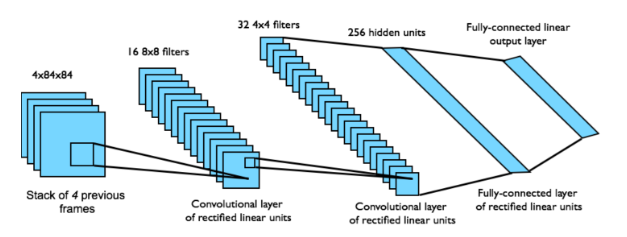

In [9]:
Image("c1.png") 

## 5. Experiments

-세가지 setting

1. reward structure: 모든 positive rewards은 1로, 모든 negative rewards는 1로 고정, 변화 없음은 0으로 고정.

이유: loss function으로 gradient를 할 때 derivatives의 error의 스케일을 제한하고, 모든 게임에 동일한 learning rate를 사용하기 쉽게 만들기 때문

2.
RMSProp Algorithm -최적화 알고리즘으로 32 size minibatch를 RMSProp 알고리즘에 적용, 

E-greedy Algorithm – Behavior Policy로, 처음부터 100만번 째 frame까지 1에서 0.1까지 동일한 비율로 감소하는 epsilon 사용, 그 이후에는 0.1로 고정

3.Frame skipping technique – agent가 모든 frame 대신 모든 임의의 k번째 frame통해 action들을 선택. 마지막 행동은 skipped된 frames에 반복적용 -> 실행시간은 같지만 훨씬 적은 연산, k배 많이 게임 진행 가능


### Training and Stability

-이 논문의 evaluation metric: games 통해 평균화된 rewar를 토대로 game 또는 episode에서 평균적으로 얻은 보상. -> training 동안의 total reward 주기적으로 계산해야 함.

-그러나 학습을 진행하면서 policy의 weights 변화가 state의 distribution의 큰 변화 줄 수 있으므로 noisy함을 확인할 수 있음.(논문의 figure2 왼쪽 두 그래프)

-metric -> policy’s estimated action-value function Q : Q-function은 agent가 주어진 state에서 policy로부터 얻을 수 있는 reward를 얼마나 많이 discount할 수 있는지에 대해 평가, 훨씬 smooth하게 증가(오른쪽 두 그래프)


### Visualizing the Value Function

- point A: screen 왼쪽에 enemy가 등장하였을 때, predicted value가 jump

- point B: enemy를 발견하여 발사한 미사일이 적을 맞추려 할 때 predicted value 상승

- point C: Screen에서 enemy가 사라졌을 때 predicted value 다시 감소 


## 6. Conclusion

-RL을 위한 새로운 deep learning model 소개

-raw pixel들 만을 입력으로 사용하여 2600가지가 넘는 어려운 control policy학습

-Stochastic Gradient Descent에 experience memory적용한 Deep Q-Learning 소개

- 성공적!


In [ ]:
#https://mangkyu.tistory.com/60 이거 참고했습니다
#많이 어려워서... 요약본에 가깝기는 하지만.. 강화학습 이해하려고 노력은 많이 했습니다.. 흑